In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from modules_ddim import UNet_conditional
from diffusion import *
from utils import *
from evaluate import *
from torch.amp import autocast
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

# Make predictions on test data

In [2]:
path = "../models/e1000_bs16/ema_ckpt.pt"
print("Loading: ", path)

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model = UNet_conditional(length=1024,
                         feat_num=3,
                         device=device).to(device)
ckpt = torch.load(path,
                  map_location=device,
                  weights_only=True
                  )
model.load_state_dict(ckpt)

sampler = EdmSampler(net=model, num_steps=100)

Loading:  ../models/e1000_bs16/ema_ckpt.pt
Using device: cuda:2


In [4]:
x_real, cond_vectors, predictions = evaluate(model,
                                            sampler,
                                            device,
                                            "../../data/test_data_1024.csv",
                                            s_type='edm'
                                             )
x_real = np.array(x_real)
cond_vectors = np.array(cond_vectors)
predictions = np.array(predictions)

Testing loop: 100%|███████████████████████████████████████████████| 1567/1567 [57:22<00:00,  2.20s/it]


In [5]:
mse = np.mean((x_real - predictions) ** 2)
print(f"Mean test mse error: {mse}")

Mean test mse error: 0.010805933051705843


In [7]:
x_real

array([[0.00061579, 0.        , 0.        , ..., 0.00181409, 0.00107043,
        0.00106402],
       [0.00087057, 0.        , 0.        , ..., 0.00079498, 0.00183476,
        0.00029969],
       [0.00010624, 0.00054038, 0.        , ..., 0.        , 0.00081565,
        0.00106402],
       ...,
       [0.00112534, 0.        , 0.        , ..., 0.00054021, 0.00056087,
        0.00055447],
       [0.00087057, 0.        , 0.        , ..., 0.00155931, 0.00157998,
        0.00029969],
       [0.        , 0.        , 0.        , ..., 0.00079498, 0.0013252 ,
        0.00029969]])

In [8]:
predictions

array([[[0.05712809, 0.14783649, 0.1055338 , ..., 0.1559988 ,
         0.05619682, 0.06101481]],

       [[0.0654207 , 0.08411506, 0.0900383 , ..., 0.04579741,
         0.08410562, 0.07817438]],

       [[0.06355624, 0.09766211, 0.17254969, ..., 0.16542459,
         0.09703197, 0.0652689 ]],

       ...,

       [[0.07223254, 0.06842723, 0.12147555, ..., 0.14046477,
         0.11092713, 0.06702153]],

       [[0.07017515, 0.11315534, 0.08406298, ..., 0.13001953,
         0.0679481 , 0.07350348]],

       [[0.09756981, 0.0492923 , 0.11446726, ..., 0.12483751,
         0.11285754, 0.08341274]]])

In [9]:
cond_vectors

array([[0.31632441, 0.3391147 , 0.        ],
       [0.27736008, 0.44142237, 0.        ],
       [0.67720926, 0.2812798 , 0.        ],
       ...,
       [0.40499091, 0.84475654, 0.        ],
       [0.37738329, 0.6054191 , 0.        ],
       [0.71750009, 0.09133745, 0.        ]])

# Save predictions

In [11]:
x_real_str = [','.join(map(str, row)) for row in x_real]
cond_vectors_str = [','.join(map(str, row)) for row in cond_vectors]
preds_str = [','.join(map(str, row)) for row in predictions[:, 0, :]]

df = pd.DataFrame({'x_real': x_real_str, 'cond_vectors': cond_vectors_str, 'predictions': preds_str})
df.to_csv('../results/predictions/preds_edm_UNet_conditional_1024.csv', index=False)

In [12]:
df.head()

,x_real,cond_vectors,predictions
0,"0.0006157915922813118,0.0,0.0,0.00149204465560...","0.3163244128227234,0.3391146957874298,0.0","0.057128094136714935,0.14783649146556854,0.105..."
1,"0.0008705681539140642,0.0,0.0,0.00174682121723...","0.27736008167266846,0.44142237305641174,0.0","0.06542070209980011,0.08411505818367004,0.0900..."
2,"0.0001062385126715526,0.0005403818213380873,0....","0.6772092580795288,0.2812798023223877,0.0","0.0635562390089035,0.09766210615634918,0.17254..."
3,"0.0008705681539140642,3.082872717641294e-05,0....","0.5888327956199646,0.7273106575012207,0.0","0.06381502002477646,0.08365252614021301,0.1063..."
4,"0.0003610150597523898,0.0,0.0,0.00123726809397...","0.3009049892425537,0.22526775300502777,0.0","0.07646141946315765,0.08651195466518402,0.0895..."


In [13]:
# Load data
df = pd.read_csv('../results/predictions/preds_edm_UNet_conditional_1024.csv')

# Function to convert comma-separated strings to lists of floats
def str_to_float_list(s):
    return np.array(list(map(float, s.split(','))))

x_real = np.array([str_to_float_list(row) for row in df['x_real']])
cond_vectors = np.array([str_to_float_list(row) for row in df['cond_vectors']])
predictions = np.array([str_to_float_list(row) for row in df['predictions']])

df.head()

,x_real,cond_vectors,predictions
0,"0.0006157915922813118,0.0,0.0,0.00149204465560...","0.3163244128227234,0.3391146957874298,0.0","0.057128094136714935,0.14783649146556854,0.105..."
1,"0.0008705681539140642,0.0,0.0,0.00174682121723...","0.27736008167266846,0.44142237305641174,0.0","0.06542070209980011,0.08411505818367004,0.0900..."
2,"0.0001062385126715526,0.0005403818213380873,0....","0.6772092580795288,0.2812798023223877,0.0","0.0635562390089035,0.09766210615634918,0.17254..."
3,"0.0008705681539140642,3.082872717641294e-05,0....","0.5888327956199646,0.7273106575012207,0.0","0.06381502002477646,0.08365252614021301,0.1063..."
4,"0.0003610150597523898,0.0,0.0,0.00123726809397...","0.3009049892425537,0.22526775300502777,0.0","0.07646141946315765,0.08651195466518402,0.0895..."


# Intro into data

In [14]:
# Find indices and values greater than 0.5
indices = np.where(np.any(x_real > 0.5, axis=1))[0]
filtered_values = [x_real[idx][x_real[idx] > 0.5] for idx in indices]
filtered_predictions = [predictions[idx][x_real[idx] > 0.5] for idx in indices]

# Flatten results and take the first 50
flat_filtered_values = np.concatenate(filtered_values)[:50]
flat_filtered_predictions = np.concatenate(filtered_predictions)[:50]

# Print the results side by side
print("Filtered Values (greater than 0.5) from x_real and corresponding Predictions:")
for value, prediction in zip(flat_filtered_values, flat_filtered_predictions):
    print(f"{value:.5f}\t\t\t{prediction:.5f}")

Filtered Values (greater than 0.5) from x_real and corresponding Predictions:
0.51206			0.46759
0.51917			0.40598
0.53315			0.40846
0.50054			0.38506
0.51451			0.47374
0.57714			0.57334
0.62085			0.58890
0.67306			0.69457
0.75889			0.75198
0.82681			0.79427
0.89323			0.87485
0.94675			0.92320
0.98621			1.00000
1.00000			0.96538
1.00000			0.99289
1.00000			0.98444
0.98376			0.96767
0.91490			0.90088
0.86643			0.85211
0.81041			0.77756
0.76278			0.71703
0.68614			0.68728
0.66184			0.60702
0.57601			0.56766
0.53988			0.44759
0.50519			0.44491
0.51203			0.42276
0.53162			0.51356
0.50025			0.47997
0.54682			0.53388
0.58773			0.60998
0.63280			0.64231
0.71023			0.71833
0.77866			0.80115
0.83973			0.85342
0.89197			0.89161
0.93576			0.94499
0.97427			0.97457
0.95795			1.00000
0.98165			0.94290
0.95217			0.93962
0.89197			0.93719
0.85242			0.81258
0.80047			0.79455
0.75615			0.81398
0.69047			0.69327
0.66184			0.59125
0.57448			0.51119
0.53402			0.49134
0.50635			0.51580


In [15]:
# Find indices where predictions > 0.8 and corresponding x_real < 0.5
indices = np.where((predictions > 0.8) & (x_real < 0.1))

# Extract filtered values from x_real and predictions
filtered_x_real = x_real[indices]
filtered_predictions = predictions[indices]

# Print the results side by side
print("Filtered x_real (values < 0.1) and corresponding Predictions (values > 0.8):")
for x_val, pred_val in zip(filtered_x_real.flatten(), filtered_predictions.flatten()):
    print(f"{x_val:.5f}\t\t\t{pred_val:.5f}")

Filtered x_real (values < 0.1) and corresponding Predictions (values > 0.8):


# Visualization of results

In [17]:
wavelengths = np.load('../../data/wavelengths.npy')

In [18]:
wavelengths

array([ 634.835144,  635.296997,  635.758911, ..., 1123.063232,
       1123.557739, 1124.052368])

## Plot predictions

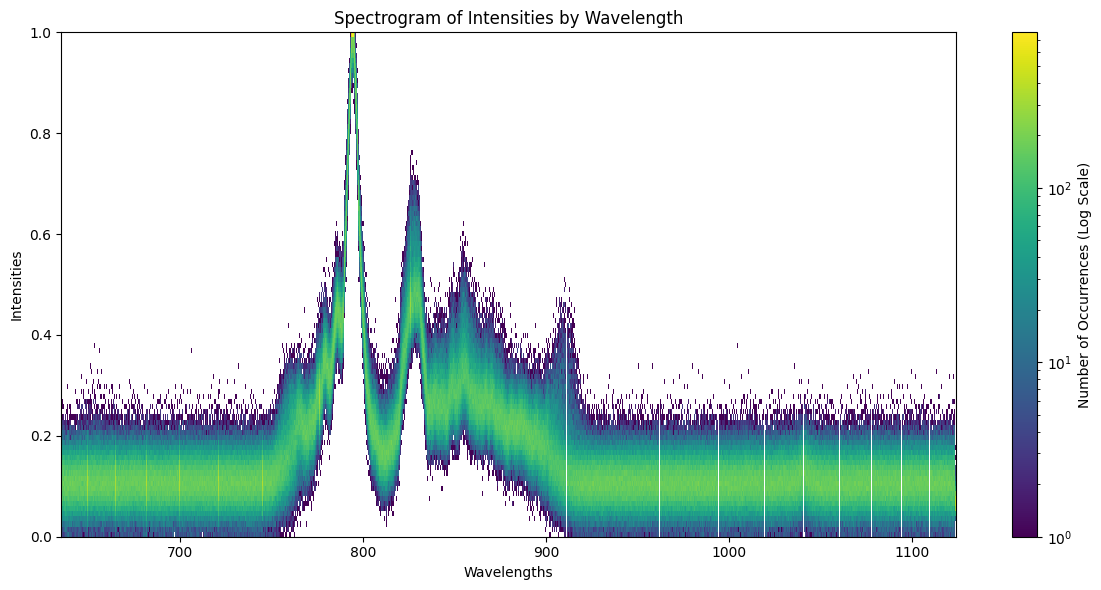

In [19]:
create_spectrogram(wavelengths, predictions, label="Spectrogram of Intensities by Wavelength")

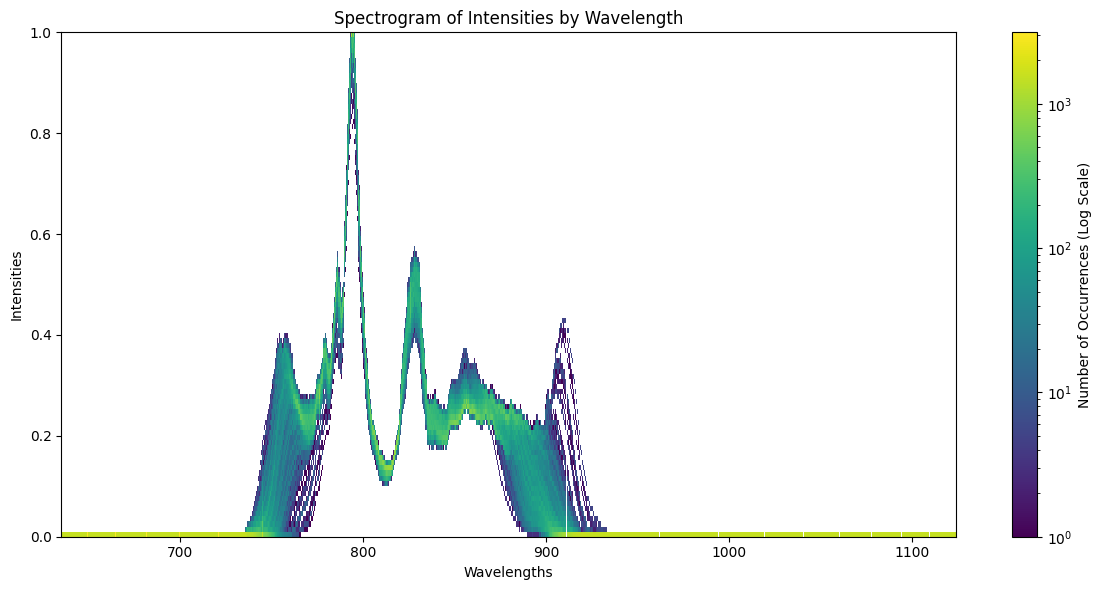

In [20]:
create_spectrogram(wavelengths, x_real, label="Spectrogram of Intensities by Wavelength")

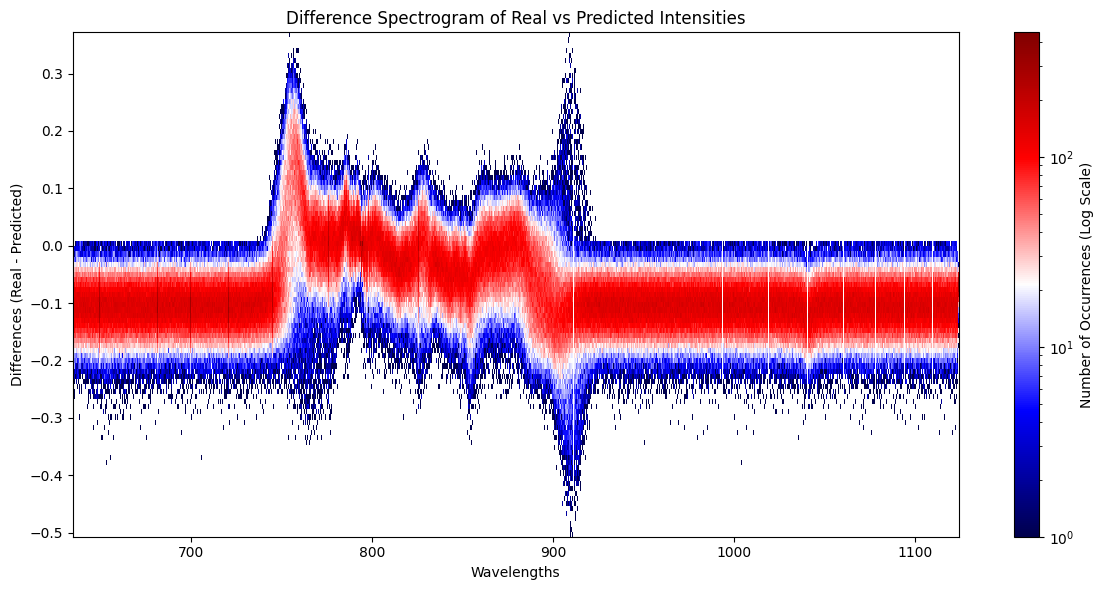

In [21]:
create_difference_spectrogram(wavelengths, 
                              x_real, 
                              predictions, 
                              label="Difference Spectrogram of Real vs Predicted Intensities")

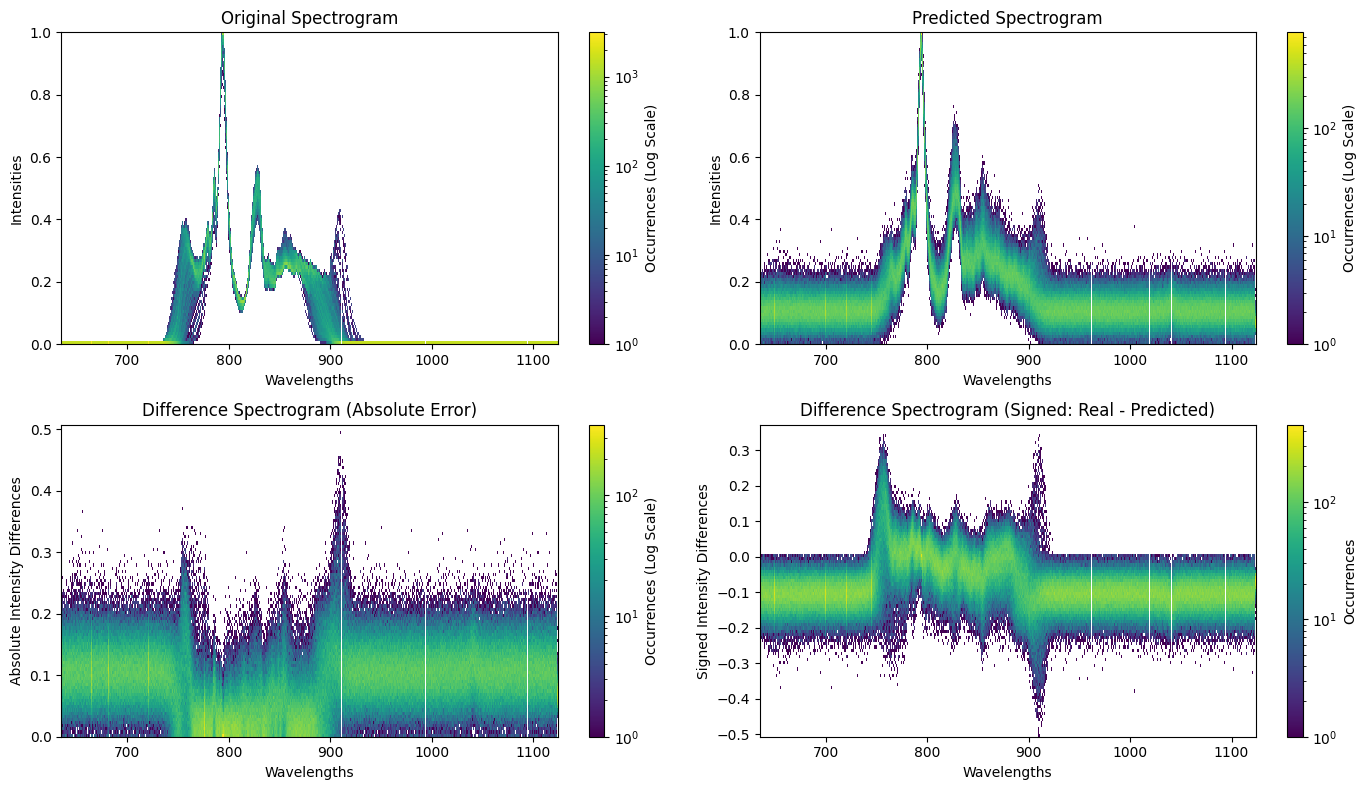

In [22]:
create_combined_spectrogram(wavelengths, 
                            x_real, 
                            predictions)

## Influence of parameters to predictions

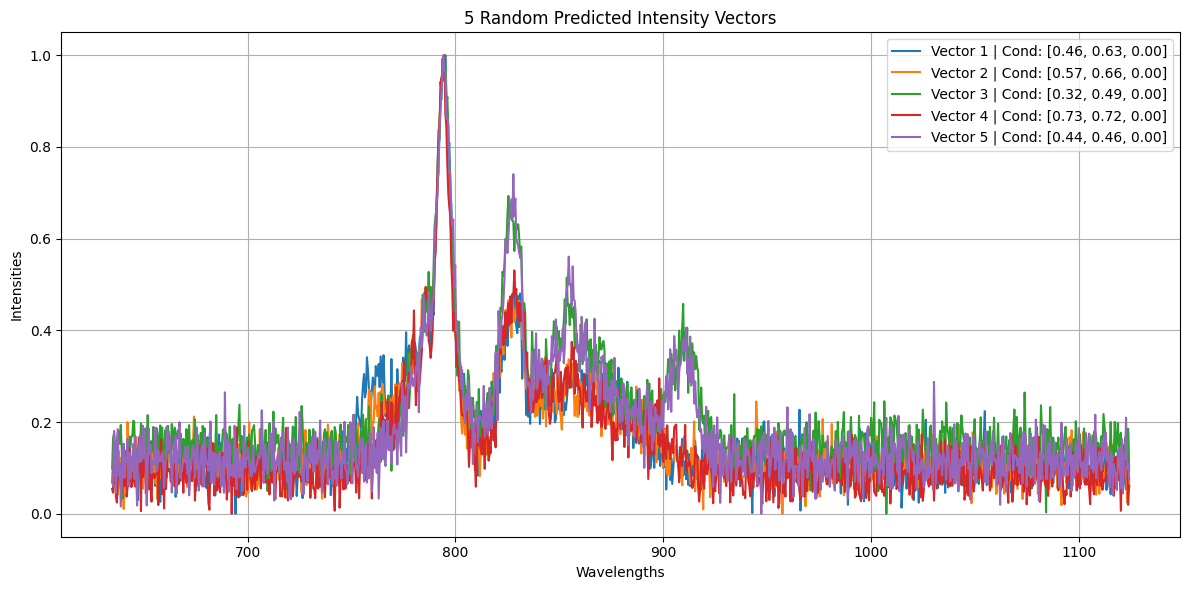

In [42]:
plot_random_intensity_vectors(wavelengths, predictions, cond_vectors)

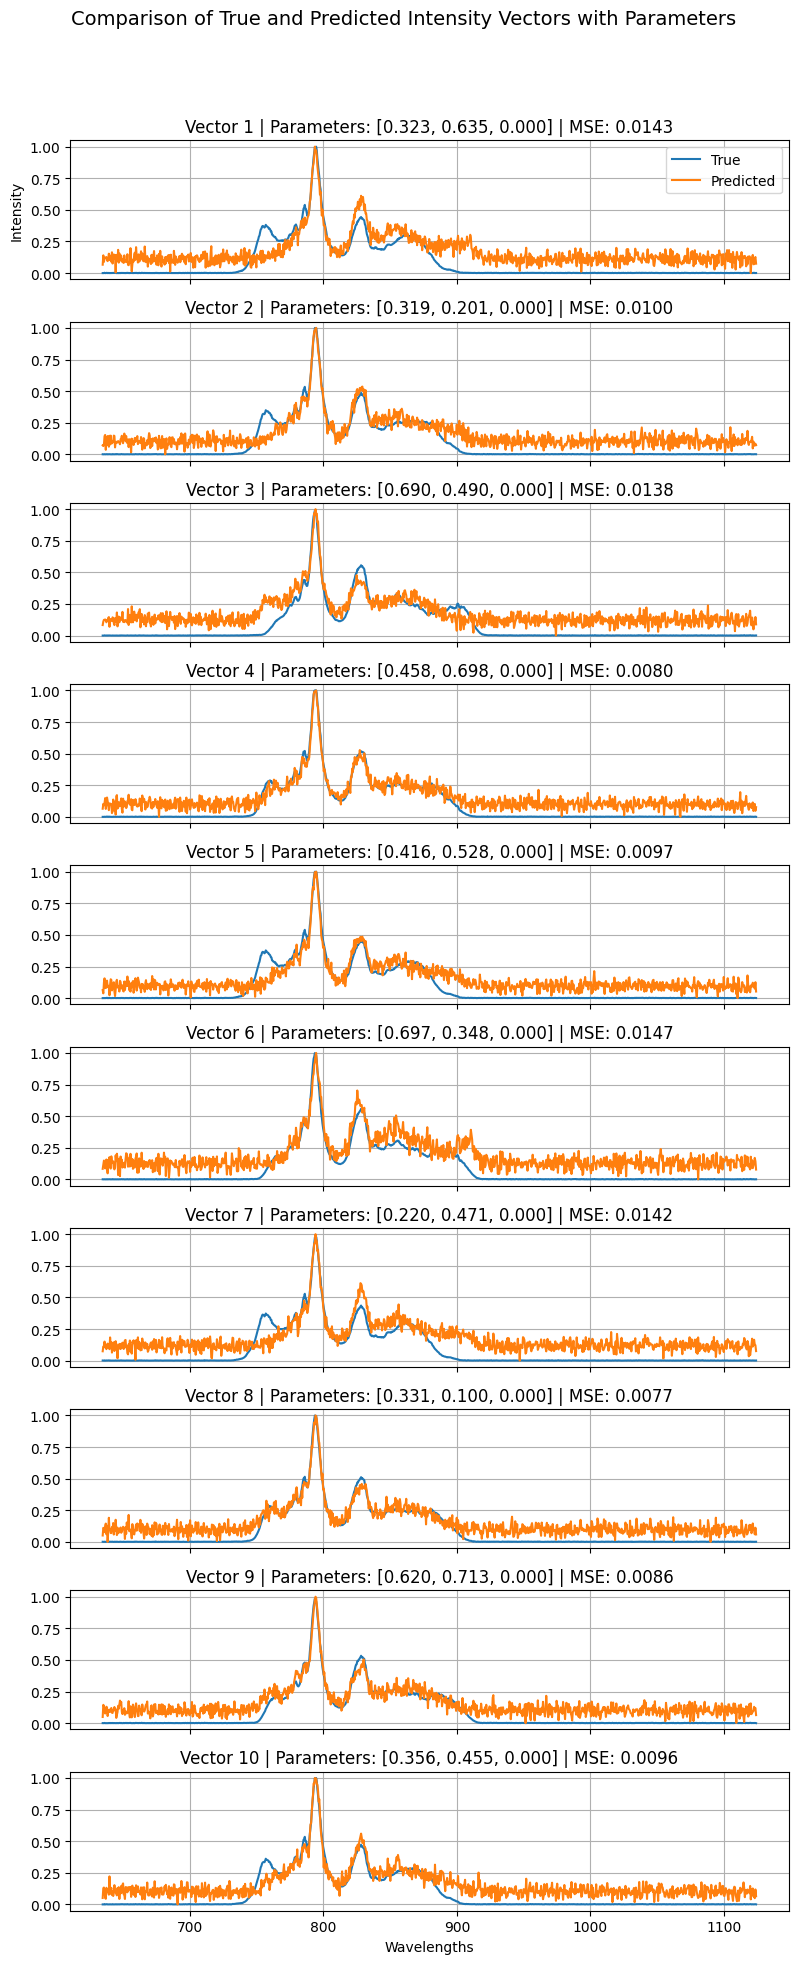

In [40]:
indices = np.random.choice(len(x_real), size=10, replace=False)

selected_real, selected_predicted, selected_conditions = plot_combined_intensity_vectors_with_parameters(
    wavelengths, x_real, predictions, cond_vectors, indices, num_vectors=10
)

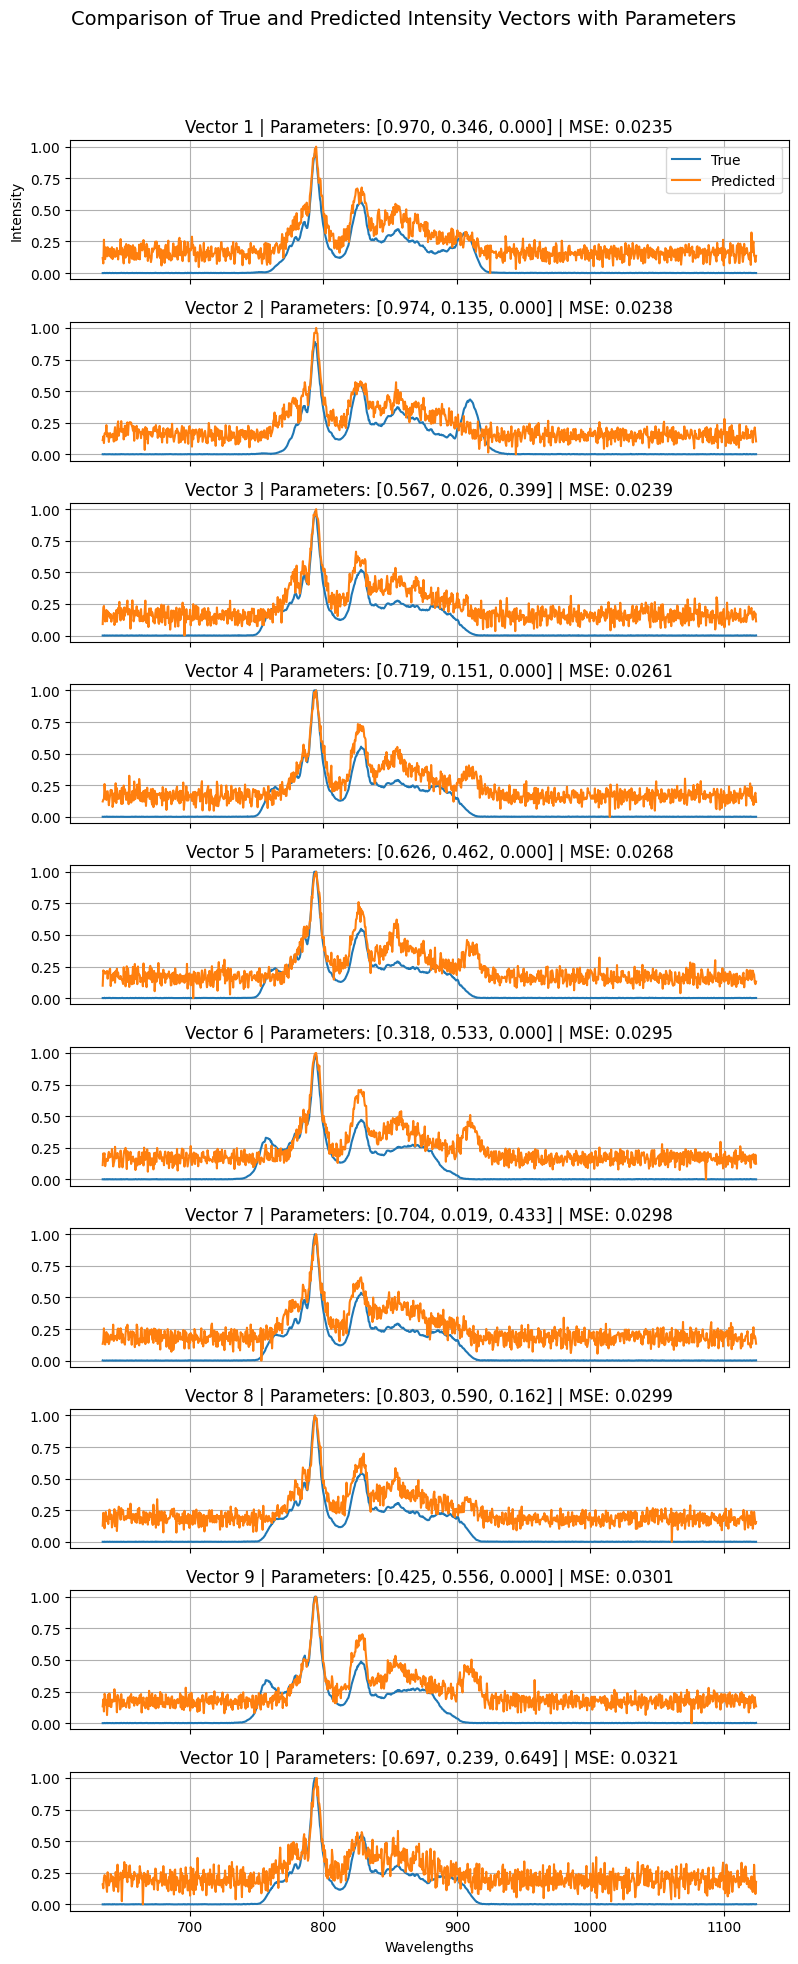

In [25]:
worst_indices = get_worst_mse_indices(x_real, predictions, n=10)
selected_real, selected_predicted, selected_conditions = plot_combined_intensity_vectors_with_parameters(
    wavelengths, x_real, predictions, cond_vectors, worst_indices, num_vectors=10
)

MSE Statistics:
Mean: 0.0107
Median: 0.0099
Standard Deviation: 0.0032
Min: 0.0059
Max: 0.0321
Range: 0.0262
Median (Q2): 0.0099
First Quartile (Q1): 0.0086
Third Quartile (Q3): 0.0120
Interquartile Range (IQR): 0.0034
Upper Whisker: 0.0171
Number of Outliers: 86.0000
Outliers: [0.018082863236955914, 0.0238429055189237, 0.022731542003400537, 0.018487120256273984, 0.018337733398421173, 0.02000361679462094, 0.01777965260825461, 0.017683154840747208, 0.017085473109785657, 0.023932474311111444]...


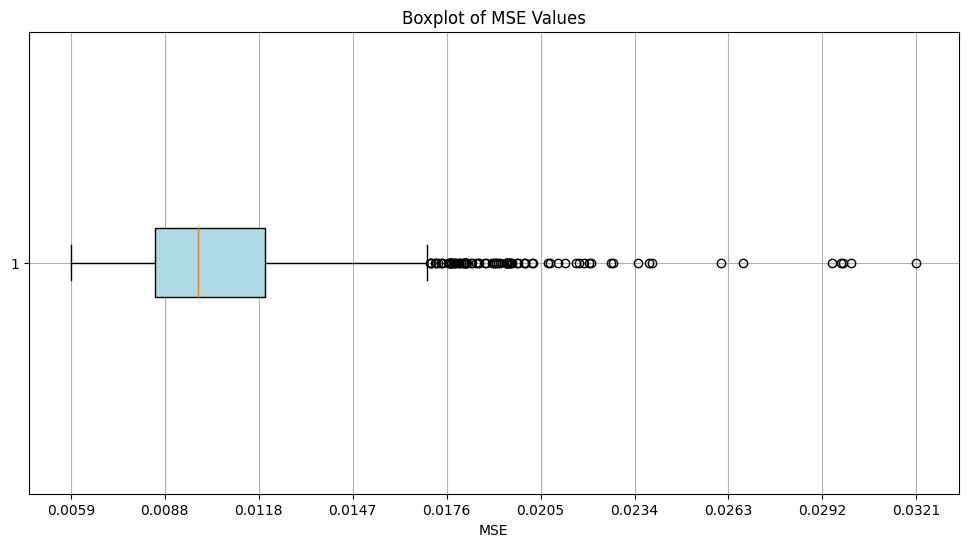

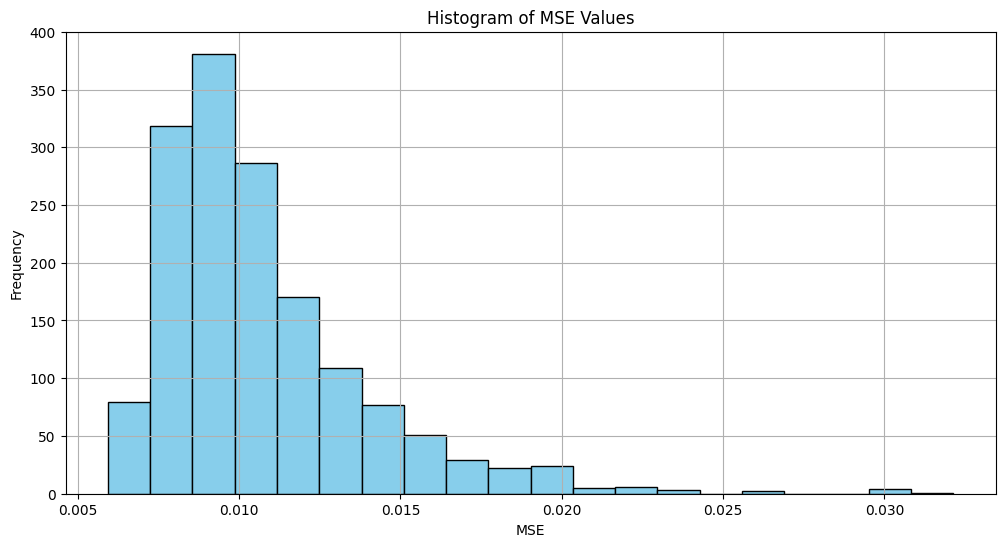

In [26]:
mse_stats = mse_statistics(x_real, predictions)


Number of vectors with high MSE (above upper whisker): 86
Number of vectors with low MSE (below or equal to upper whisker): 1481

Statistics for high MSE conditional vectors:
  Mean: [0.582982   0.38414665 0.05182378]
  Median: [0.57061434 0.39134221 0.        ]
  Std: [0.24354419 0.20371192 0.14196543]
  Min: [0.18264106 0.01863214 0.        ]
  Max: [1.         0.91757828 0.64880955]

Statistics for low MSE conditional vectors:
  Mean: [0.43330462 0.46118864 0.00374084]
  Median: [0.41589317 0.47834998 0.        ]
  Std: [0.15916458 0.21283266 0.0357914 ]
  Min: [0.         0.00644275 0.        ]
  Max: [0.97409213 1.         0.43452382]


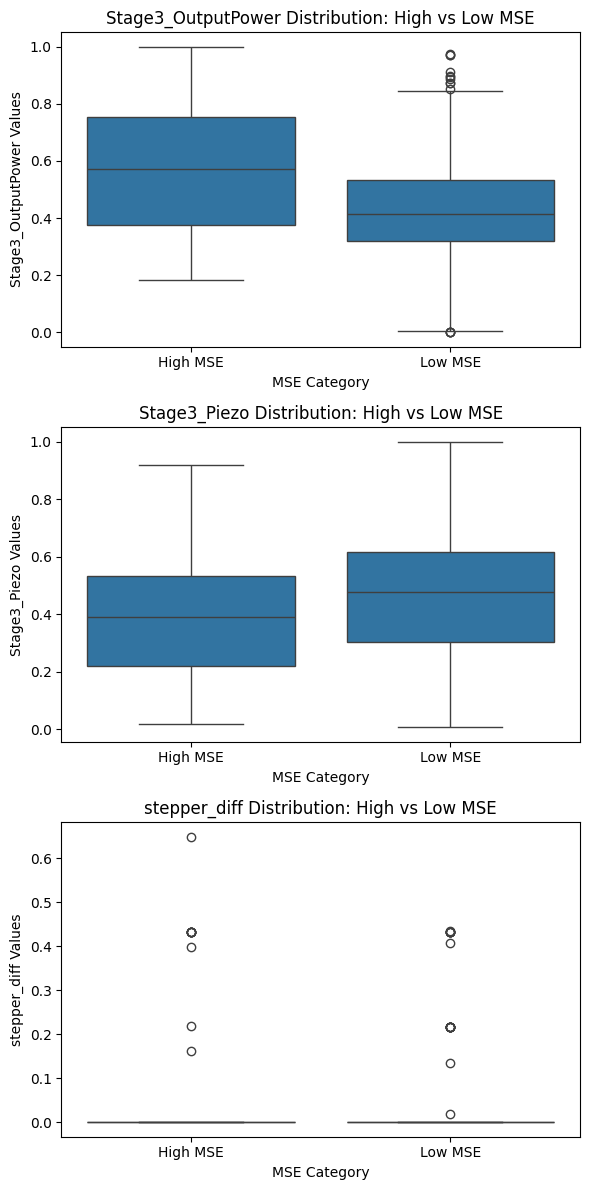

In [27]:
mse = np.mean((x_real - predictions) ** 2, axis=1)
parameter_names = ['Stage3_OutputPower', 'Stage3_Piezo', 'stepper_diff']
analyze_mse_and_cond_vectors(mse, cond_vectors, parameter_names)

## Try Random conditional vectors

In [30]:
df = pd.read_csv("../../data/test_data_1024.csv")
df_subset = df.head(20)
new_cond_vectors = np.array([
    [ 214935.09855301,  269804.25447773, -418456.16068934],
    [ -93975.81857062,  120292.39937219,   82977.52669794],
    [ -93975.81857062,  -120292.39937219,   82977.52669794],
    [0,   0,   0],
    [  1,   1,  1],
    
    [ 1,    0,   0],
    [ 0,    1,   0],
    [ 0,    0,   1],
    [1,   1,   0],
    [  0,   1,  1],
    
    [ 1,    0,   1],
    [ 0.1,    0.1,   0],
    [ 0.3,    0.3,   0],
    [ 0.5,    0.5,   0],
    [ 0.7,    0.7,   0],
    
    [ 0.9,    0.9,   0],
    [ 0.1,    0.9,   0],
    [ 0.9,    0.1,   0],
    [ 0.5,    0.3,   0],
    [ 0.3,    0.5,   0],

])

df_subset['cond_vector'] = new_cond_vectors.tolist()
df_subset.to_csv("../../data/data_nonsense.csv", index=False)

/tmp/ipykernel_2090636/2430717549.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['cond_vector'] = new_cond_vectors.tolist()


In [31]:
df_subset

,time,idx,cond_vector,intensities
0,2024-06-17 10:11:38.558800220,18,"[214935.09855301, 269804.25447773, -418456.160...","0.0006157916174009492,0.0,0.0,0.00149204461740..."
1,2024-06-17 10:20:03.601318836,80,"[-93975.81857062, 120292.39937219, 82977.52669...","0.0008705681707713021,0.0,0.0,0.00174682117077..."
2,2024-06-17 10:15:08.508659840,48,"[-93975.81857062, -120292.39937219, 82977.5266...","0.00010623851066024335,0.0005403818340281786,0..."
3,2024-06-17 10:12:54.698517799,40,"[0.0, 0.0, 0.0]","0.0008705681707713021,3.082872728747282e-05,0...."
4,2024-06-17 10:17:33.703059673,57,"[1.0, 1.0, 1.0]","0.00036101506403059627,0.0,0.0,0.0012372680640..."
5,2024-06-17 10:23:07.478772640,116,"[1.0, 0.0, 0.0]","0.0008705681707713021,0.0,0.0,0.00174682117077..."
6,2024-06-17 10:25:01.330039501,119,"[0.0, 1.0, 0.0]","0.001125344724141655,0.0,0.0,0.003020703937629..."
7,2024-06-17 10:16:29.521095276,57,"[0.0, 0.0, 1.0]","0.00036101506403059627,0.0,0.0,0.0007277149572..."
8,2024-06-17 10:13:30.400424957,40,"[1.0, 1.0, 0.0]","0.0008705681707713021,0.0,0.0,0.00225637427751..."
9,2024-06-17 10:22:44.214152813,101,"[0.0, 1.0, 1.0]","0.00010623851066024335,0.00028560528065782573,..."


In [33]:
x_real_nonsense, cond_vectors_nonsense, predictions_nonsense = evaluate(model,
                      sampler,
                      device,
                     "../../data/data_nonsense.csv")
x_real_nonsense = np.array(x_real_nonsense)
cond_vectors_nonsense = np.array(cond_vectors_nonsense)
predictions_nonsense = np.array(predictions_nonsense)

Testing loop: 100%|███████████████████████████████████████████████████| 20/20 [00:44<00:00,  2.23s/it]


In [37]:
predictions_nonsense[:,0,:]

array([[1.        , 0.07272727, 0.44545454, ..., 0.45454547, 0.        ,
        0.37272727],
       [0.33333334, 0.        , 0.82539684, ..., 0.82539684, 1.        ,
        0.50793654],
       [0.1891892 , 0.        , 0.83783782, ..., 0.83783782, 1.        ,
        0.5945946 ],
       ...,
       [0.10025615, 0.19172253, 0.13597624, ..., 0.1721866 , 0.16121195,
        0.0956334 ],
       [0.06843147, 0.10724884, 0.01311368, ..., 0.19775033, 0.09962374,
        0.06231185],
       [0.06859016, 0.06157509, 0.09112766, ..., 0.13231118, 0.14283592,
        0.05168432]])

In [36]:
x_real_nonsense

array([[6.15791592e-04, 0.00000000e+00, 0.00000000e+00, ...,
        1.81409006e-03, 1.07042794e-03, 1.06402254e-03],
       [8.70568154e-04, 0.00000000e+00, 0.00000000e+00, ...,
        7.94983876e-04, 1.83475751e-03, 2.99692882e-04],
       [1.06238513e-04, 5.40381821e-04, 0.00000000e+00, ...,
        0.00000000e+00, 8.15651321e-04, 1.06402254e-03],
       ...,
       [1.06238513e-04, 0.00000000e+00, 0.00000000e+00, ...,
        2.85430753e-04, 8.15651321e-04, 0.00000000e+00],
       [8.70568154e-04, 0.00000000e+00, 0.00000000e+00, ...,
        3.06542061e-05, 1.07042794e-03, 1.57357566e-03],
       [1.06238513e-04, 0.00000000e+00, 0.00000000e+00, ...,
        2.85430753e-04, 5.13216801e-05, 4.49163417e-05]])

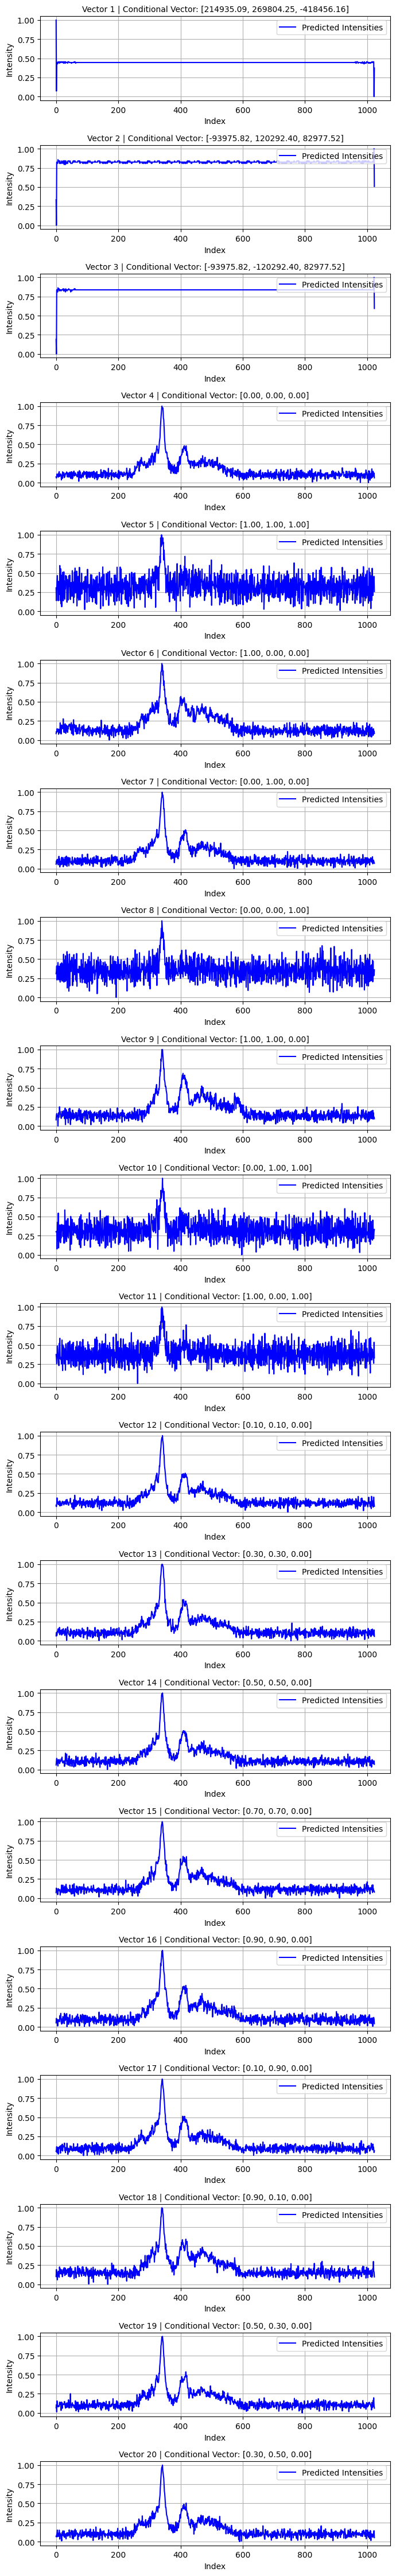

In [38]:
plot_predictions_with_cond_vectors(predictions_nonsense[:,0,:], cond_vectors_nonsense)